# Gaussian Mixture Model Estimation using Expectation Maximization

Miki Seltzer (miki.seltzer@berkeley.edu)<br>
Machine Learning at Scale<br>
W261-2, Spring 2016<br>

### Introduction
This is a map-reduce version of expectation maximization algorithm for a mixture of Gaussian models. There are two MRJob packages, MR_GMM_EM_Initialize and MR_GMM_EM_Iterate. The driver calls the MRJob packages and manages the iteration.

The multivariate Gaussian probability density function is defined as follows:

$$
\newcommand\given[1][]{\:#1\vert\:}
\begin{equation}
\begin{split}
\text{(0)} \qquad \mathcal{N} \big( \boldsymbol{x} \given[\big] \boldsymbol{\mu}, \boldsymbol{\Sigma} \big) =
\frac{1}{(2 \pi)^{n/2} \big| \boldsymbol{\Sigma} \big| ^{1/2}} \exp{\bigg[-\frac{1}{2} (\boldsymbol{x}-\boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\boldsymbol{x}-\boldsymbol{\mu}) \bigg]}
\end{split}
\end{equation}
$$

### Expectation Step
Given priors, mean vector and covariance matrix, calculate the probability that each data point belongs to a class.

$$
\newcommand\given[1][]{\:#1\vert\:}
\begin{equation}
\begin{split}
\text{(1)}\qquad p \big( \omega_k \given[\big] \boldsymbol{x}^{(i)}, \theta \big) = 
\frac{\pi_k \mathcal{N} \big( \boldsymbol{x}^{(i)} \given[\big] \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k \big)}
{\sum_{j=1}^K \pi_j \mathcal{N} \big( \boldsymbol{x}^{(i)} \given[\big] \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j \big)}
\end{split}
\end{equation}
$$

### Maximization Step
Given probabilities, update priors, mean and covariance

$$
\newcommand\given[1][]{\:#1\vert\:}
\begin{equation}
\begin{split}
\text{(2)}\qquad \hat{\boldsymbol{\mu}}_k &= 
\frac{1}{n_k} \sum_{i=1}^n p \big( \omega_k \given[\big] \boldsymbol{x}^{(i)}, \theta \big) \boldsymbol{x}^{(i)} \\
\text{(3)}\qquad \hat{\boldsymbol{\Sigma}}_k &= 
\frac{1}{n_k} \sum_{i=1}^n p \big( \omega_k \given[\big] \boldsymbol{x}^{(i)}, \theta \big) \big( \boldsymbol{x}^{(i)} - \hat{\boldsymbol{\mu}}_k \big) \big( \boldsymbol{x}^{(i)} - \hat{\boldsymbol{\mu}}_k \big)^T \\
\text{(4)}\qquad \hat{\pi}_k &= \frac{n_k}{n} \text{ where } n_k=\sum_{i=1}^n p \big( \omega_k \given[\big] \boldsymbol{x}^{(i)}, \theta \big)
\end{split}
\end{equation}
$$

### Data Generation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import json

# Define the size of our clusters
size1 = size2 = size3 = 1000

# Define our clusters
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)

# Create one large array
data = np.array(samples1)
data = np.append(data,samples2, axis=0)
data = np.append(data,samples3, axis=0)

# Randomize the array, then write it to file
data = data[np.random.permutation(size1 + size2 + size3),]
with open('GMM_data.txt', 'w') as f:
    for row in data.tolist():
        json.dump(row, f)
        f.write('\n')

### Data Visualization

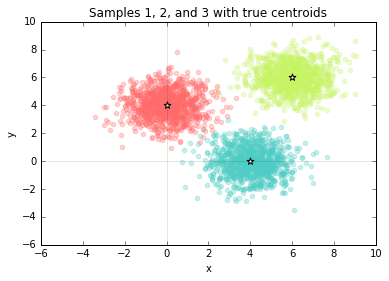

In [2]:
def plot_samples():
    # Plot axis
    plt.axhline(0, color='black', alpha=0.1)
    plt.axvline(0, color='black', alpha=0.1)
    
    # Plot data points
    plt.scatter(samples1[:, 0], samples1[:, 1], color='#4ECDC4', alpha=0.3)
    plt.scatter(samples2[:, 0], samples2[:, 1], color='#C7F464', alpha=0.3)
    plt.scatter(samples3[:, 0], samples3[:, 1], color='#FF6B6B', alpha=0.3)
    
    # Plot centroids
    plt.scatter([4], [0], marker='*', s=50, color='white', edgecolor='black')
    plt.scatter([6], [6], marker='*', s=50, color='white', edgecolor='black')
    plt.scatter([0], [4], marker='*', s=50, color='white', edgecolor='black')
    
    # Label graph
    plt.title('Samples 1, 2, and 3 with true centroids')
    plt.xlabel('x')
    plt.ylabel('y')

plot_samples()

### Initialization
Assumption is that we know that there are 3 components to the model.

Variable names equate to equations (1), (2), (3) and (4) as follows:
- `phi` is the array containing each $\pi_k$ and are the prior class probabilities
- `centroids` is the array containing each $\mu_k$ and are the current means
- `covInvs` is the array containing each $\Sigma^{-1}_k$ and are the current inverse covariance matrices

In [3]:
%%writefile MR_GMM_EM_Initialize.py
from mrjob.job import MRJob
import numpy as np
from random import sample
import json
from math import pi, sqrt, exp, pow

class GMM_EM_Initialize(MRJob):
    
    """
    Job configuration details
    """
    # Set default protocol
    DEFAULT_PROTOCOL='json'
    
    # Define initializer
    def __init__(self, *args, **kwargs):
        super(GMM_EM_Initialize, self).__init__(*args, **kwargs)
        
        # Set number of mappers
        self.numMappers = 1
        
        # Initialize count
        self.count = 0
        
    # Configure job options
    def configure_options(self):
        super(GMM_EM_Initialize, self).configure_options()
        self.add_passthrough_option('--k', dest='k', default=3, type='int', 
                                    help='k: number of densities in mixture')
        self.add_passthrough_option('--pathName', dest='pathName', default='', type='str',
                                    help='pathName: path name where intermediateResults.txt is stored')
        
    """
    Mapper
    - Output a few data points to initialize centroids
    """
    def mapper(self, _, line):
        
        # We are going to just output 2 * k points
        if self.count < 2 * self.options.k:
            self.count += 1
            yield (1, line)
            
    """
    Reducer
    - Essentially, this is an identity reducer, but we need to initialize centroids
    - Collect the 2 * k points from the mapper, choose k of them for starting points
    - Emit all values
    """
    def reducer(self, key, values):
        
        #############################################
        # Initialize centroids
        #############################################
        
        k = self.options.k
        sampleCentroids = []
        
        # Append each point from the mapper to centroids
        # After appending, emit them
        for val in values:
            sampleCentroids.append(json.loads(val))
            yield 1, val
            
        # Sample k points from the sample centroids list
        sampleIndex = sample(range(len(sampleCentroids)), k)
        centroids = []
        for i in sampleIndex:
            centroids.append(sampleCentroids[i])
        
        # centroids = our starting centroid points
        
        
        #############################################
        # Use the covariance of the centroids as the 
        # starting guess for covariance
        #############################################
        
        # 1. Calculate mean of centroids
        means = np.array(centroids[0])
        
        for i in range(1, k):
            means += np.array(centroids[i])
        
        means /= float(k)
        
        # 2. Accumulate the deviations
        covariance = np.zeros((len(means), len(means)), dtype=float)
        
        for c in centroids:
            deviation = np.array(c) - means
            
            for i in range(len(means)):
                covariance[i, i] += deviation[i] ** 2
        
        covariance /= float(k)
        
        # Get the inverse of the covariance matrix
        covInvOne = np.linalg.inv(covariance)
        
        # Repeat covariance inverse k times
        # We will have a covariance inverse for each centroid
        covInvs = [covInvOne.tolist()]*k
        
        # For debugging purposes
        jsonDebug = json.dumps([centroids, 
                                means.tolist(), 
                                covariance.tolist(), 
                                covInvOne.tolist(),
                                covInvs])
        debugPath = self.options.pathName + 'debug.txt'
        with open(debugPath, 'w') as outfile:
            outfile.write(jsonDebug)
        
        
        #############################################
        # Use 1/k as the starting guess for the phis
        #############################################
        
        phi = np.zeros(k, dtype=float)
        
        for i in range(k):
            phi[i] = 1.0/float(k)
            
            
        #############################################
        # Output our initializations
        #############################################
        
        outputList = [phi.tolist(), centroids, covInvs]
        jsonOut = json.dumps(outputList)
        
        # Write to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        with open(fullPath, 'w') as outfile:
            outfile.write(jsonOut)
            
        
if __name__ == '__main__':
    GMM_EM_Initialize.run()

Overwriting MR_GMM_EM_Initialize.py


### Iteration
Assumption is that we know that there are 3 components to the model.

Variable names equate to equations (1), (2), (3) and (4) as follows:
- `weightVector` is the array of weights for each data point, where `weightVector[k]` is $p \big( \omega_k \given[\big] \boldsymbol{x}^{(i)}, \theta \big)$ (we normalize after weights for all clusters have been calculated)
- `new_phi` is the partial sums of the `phi` values
- `new_centroids` is the partial sums of the `centroids` values
- `new_covInvs` is the partial sums of the `covInvs` values
- These arrays are then totaled, and divided appropriately in the reducer to yield `finalPhi`, `finalCentroids` and `finalCov`.

In [4]:
%%writefile MR_GMM_EM_Iterate.py
from mrjob.job import MRJob
import numpy as np
import json
from math import pi, sqrt, exp, pow

# Helper function to determine probability of x
# given mean (mu) and inverse covariance (covInv)
# See equation (0)
def gaussProb(x, mu, covInv):
    
    # Get length of array
    n = len(x)
    
    # Subtract the mean from x
    xMinusMu = x - mu
    
    # Calculate numerator
    numerator = exp(-0.5*np.dot(xMinusMu, np.dot(covInv, xMinusMu)))
    
    # Calculate denominator
    # - need the determinant of covariance (detCov)
    # - det(A) = 1/det(A_inverse)
    detCov = 1/np.linalg.det(covInv)
    denominator = (pow(2.0 * pi, n / 2.0) * sqrt(detCov))
    
    # Calculate probability
    return numerator / denominator

class GMM_EM_Iterate(MRJob):
    
    """
    Job configuration details
    """
    # Set default protocol
    DEFAULT_PROTOCOL='json'
    
    # Define initializer
    def __init__(self, *args, **kwargs):
        super(GMM_EM_Iterate, self).__init__(*args, **kwargs)
        
        # Read input from JSON
        fullPath = self.options.pathName + 'intermediateResults.txt'
        with open(fullPath,'r') as infile:
            inputJSON = infile.read()
        inputList = json.loads(inputJSON)
        
        # Initialize prior class probabilities (phi), centroids and covariance inverses
        self.phi = np.array(inputList[0])
        self.centroids = np.array(inputList[1])
        self.covInvs = np.array(inputList[2])
        
        # Initialize partial sums
        self.new_phi = np.zeros_like(self.phi)
        self.new_centroids = np.zeros_like(self.centroids)
        self.new_covInvs = np.zeros_like(self.covInvs)
        
        # Set number of mappers
        self.numMappers = 1
        
        # Initialize count
        self.count = 0
        
    # Configure job options
    def configure_options(self):
        super(GMM_EM_Iterate, self).configure_options()
        self.add_passthrough_option('--k', dest='k', default=3, type='int', 
                                    help='k: number of densities in mixture')
        self.add_passthrough_option('--pathName', dest='pathName', default='', type='str',
                                    help='pathName: path name where intermediateResults.txt is stored')
        
    """
    Mapper
    - accumulate partial sums
    """
    def mapper(self, _, line):
        
        k = self.options.k
        
        #############################################
        # Expectation step: equation (1)
        # Calculated for each data point
        # weightVector[k] = p(w_k | x(i), theta)
        # where i is data point and k is the component
        #############################################
        
        x = np.array(json.loads(line))
        weightVector = np.zeros_like(self.phi)
        for i in range(k):
            weightVector[i] = self.phi[i] * gaussProb(x, self.centroids[i], self.covInvs[i])

        weightVector /= sum(weightVector)
        
        #############################################
        # Maximization step part 1: 
        # Partial sums for equations (2), (3) and (4)
        #############################################
        
        self.count += 1
        
        # Equation (4)
        self.new_phi += weightVector
        
        # Equation (2) and (3)
        for i in range(k):
            
            # Partial sum for weighted xs (eq 2)
            self.new_centroids[i] += weightVector[i] * x
            
            # Partial sum for weighted squares (eq 3)
            xMinusMu = x - self.centroids[i]
            covInc = np.zeros_like(self.new_covInvs[i])
            
            for l in range(len(xMinusMu)):
                for m in range(len(xMinusMu)):
                    covInc[l][m] = xMinusMu[l] * xMinusMu[m]
                    
            self.new_covInvs[i] += weightVector[i] * covInc
        
    """
    Mapper Final
    - emit partially accumulated count, phi, centroids and covariance inverses
    """
    def mapper_final(self):
        out = [self.count, (self.new_phi).tolist(), (self.new_centroids).tolist(), (self.new_covInvs).tolist()]
        jOut = json.dumps(out)
        yield 1, jOut
    
    """
    Reducer
    - accumulate partial sums of count, phi, centroids and covariance inverses
    - each of phi, centroids and covariance inverses are length k
    - divide
    """
    def reducer(self, key, values):
        k = self.options.k
        first = True
        
        for val in values:
            
            # If this is the first record, initialize sums
            if first:
                fields = json.loads(val)
                
                totalCount = fields[0]
                totalPhi = np.array(fields[1])
                totalCentroids = np.array(fields[2])
                totalCovInvs = np.array(fields[3])
                first = False
            
            # If this isn't the first, accumulate
            else:
                fields = json.loads(val)
                
                totalCount += fields[0]
                totalPhi += np.array(fields[1])
                totalCentroids += np.array(fields[2])
                totalCovInvs += np.array(fields[3])
        
        # Finally divide
        # This finalizes equation (4)
        finalPhi = totalPhi / totalCount
        
        # Make a copy so that we know these are the right dimensions
        finalCentroids = np.array(totalCentroids)
        finalCov = np.array(totalCovInvs)
        
        for i in range(k):
            
            # This finalizes equation (2)
            finalCentroids[i, :] = totalCentroids[i, :] / totalPhi[i]
            finalCovInv = totalCovInvs[i, :, :] / totalPhi[i]
            
            # Now we can invert to get the actual covariance
            # This finalizes equation (3)
            finalCov[i, :, :] = np.linalg.inv(finalCovInv)
            
        # Create output
        outputList = [finalPhi.tolist(), finalCentroids.tolist(), finalCov.tolist()]
        jsonOut = json.dumps(outputList)
                
        # Write to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        with open(fullPath, 'w') as outfile:
            outfile.write(jsonOut)
            
    
if __name__ == '__main__':
    GMM_EM_Iterate.run()

Overwriting MR_GMM_EM_Iterate.py


### Driver

Iteration   Centroid 1          Centroid 2          Centroid 3          
----------------------------------------------------------------------
0           (-0.6384,  5.1182)  ( 2.8585,  0.0223)  ( 6.9117,  5.0694)  
1           ( 0.7132,  4.2332)  ( 3.4648,  0.5920)  ( 5.5398,  5.4250)  
2           ( 0.3519,  4.0992)  ( 3.6057,  0.3349)  ( 5.6925,  5.8103)  
3           (-0.0100,  4.1063)  ( 3.8046,  0.1458)  ( 5.9604,  5.9675)  
4           (-0.0492,  4.0728)  ( 3.9499,  0.0251)  ( 6.0003,  5.9928)  
5           (-0.0332,  4.0430)  ( 4.0109, -0.0240)  ( 6.0006,  5.9949)  
6           (-0.0207,  4.0293)  ( 4.0300, -0.0423)  ( 6.0004,  5.9949)  
7           (-0.0154,  4.0242)  ( 4.0358, -0.0484)  ( 6.0004,  5.9948)  
8           (-0.0136,  4.0224)  ( 4.0377, -0.0503)  ( 6.0005,  5.9948)  


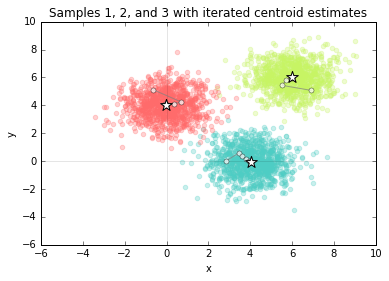

In [5]:
from MR_GMM_EM_Initialize import GMM_EM_Initialize
from MR_GMM_EM_Iterate import GMM_EM_Iterate

import json
from math import sqrt

# Helper to calculate Euclidean distance
def dist(x, y):
    sum = 0.0
    for i in range(len(x)):
        sum += (x[i] - y[i]) ** 2
    return sqrt(sum)

# Display graph at the end
def plot_iterations():
    centroidPaths = np.array(allIterations)
    
    allSamples = np.array(samples1)
    allSamples = np.append(allSamples, samples2, axis=0)
    allSamples = np.append(allSamples, samples3, axis=0)
    
    colors = ['#4ECDC4', '#C7F464', '#FF6B6B']
    
    # Plot axis
    plt.axhline(0, color='black', alpha=0.1)
    plt.axvline(0, color='black', alpha=0.1)
    
    # Plot each cluster
    for i in range(3):
        plt.scatter(allSamples[(i * 1000):((i+1) * 1000), 0], allSamples[(i * 1000):((i+1) * 1000), 1], 
                    color=colors[i], alpha=0.3, zorder=1)
        plt.plot(centroidPaths[:,i,0], centroidPaths[:,i,1], color='grey', alpha=0.7,
                 marker='o', markersize=5, markerfacecolor='white', markeredgecolor='black', zorder=2)
        plt.scatter(centroidPaths[-1,i,0], centroidPaths[-1,i,1], marker='*', s=150, 
                    color='white', edgecolor='black', zorder=3)

    # Label graph
    plt.title('Samples 1, 2, and 3 with iterated centroid estimates')
    plt.xlabel('x')
    plt.ylabel('y')

# Run the initializer to get the starting centroids
filePath = 'GMM_data.txt'
myPathName = '/home/cloudera/Documents/W261-Fall2016/Week06/'
mrJobInit = GMM_EM_Initialize(args=[filePath, '--pathName', myPathName, '--no-strict-protocol'])

with mrJobInit.make_runner() as runner:
    runner.run()

# Read the initialized values for first comparison
intermediatePath = 'intermediateResults.txt'
with open(intermediatePath, 'r') as f:
    paramJSON = f.read()
    
# Initialize delta and iteration
delta = 10
iteration = 0
allIterations = []

print '{:12s}{:<20s}{:<20s}{:<20s}'.format('Iteration', 'Centroid 1', 'Centroid 2', 'Centroid 3')
print '----------------------------------------------------------------------'
rowPrint = '{:<12d}({: 6.4f}, {: 6.4f})  ({: 6.4f}, {: 6.4f})  ({: 6.4f}, {: 6.4f})  '.format

oldParam = json.loads(paramJSON)
oldCentroids = oldParam[1]
print rowPrint(iteration, 
               oldCentroids[0][0], oldCentroids[0][1], 
               oldCentroids[1][0], oldCentroids[1][1], 
               oldCentroids[2][0], oldCentroids[2][1])
allIterations.append(oldCentroids)

while delta > 0.01:
    iteration += 1
    
    # Parse old centroid values
    oldParam = json.loads(paramJSON)
    oldCentroids = oldParam[1]
    
    # Run one iteration of algorithm
    mrJobIterate = GMM_EM_Iterate(args=[filePath, '--pathName', myPathName, '--no-strict-protocol'])
    with mrJobIterate.make_runner() as runner:
        runner.run()

    # Compare new centroids to old centroids
    with open(intermediatePath,'r') as infile:
        paramJSON = infile.read()
        
    newParam = json.loads(paramJSON)
    
    k = len(newParam[1])
    newCentroids = newParam[1]
    
    delta = 0.0
    for i in range(k):
        delta += dist(newCentroids[i], oldCentroids[i])
    
    print rowPrint(iteration, 
                   newCentroids[0][0], newCentroids[0][1], 
                   newCentroids[1][0], newCentroids[1][1], 
                   newCentroids[2][0], newCentroids[2][1])
    allIterations.append(newCentroids)
plot_iterations()